In [19]:
import pandas as pd

accounts = pd.read_csv("../data/ravenstack_accounts.csv")
subs = pd.read_csv("../data/ravenstack_subscriptions.csv")

print("Accounts shape:", accounts.shape)
print("Subscriptions shape:", subs.shape)

accounts.head()


Accounts shape: (500, 10)
Subscriptions shape: (5000, 14)


,account_id,account_name,industry,country,signup_date,referral_source,plan_tier,seats,is_trial,churn_flag
0,A-2e4581,Company_0,EdTech,US,2024-10-16,partner,Basic,9,False,False
1,A-43a9e3,Company_1,FinTech,IN,2023-08-17,other,Basic,18,False,True
2,A-0a282f,Company_2,DevTools,US,2024-08-27,organic,Basic,1,False,False
3,A-1f0ac7,Company_3,HealthTech,UK,2023-08-27,other,Basic,24,True,False
4,A-ce550d,Company_4,HealthTech,US,2024-10-27,event,Enterprise,35,False,True


In [20]:
# Convert churn_flag (True/False) to integer 1/0
accounts["churn_int"] = accounts["churn_flag"].astype(int)

# Overall churn rate (% of accounts that have churned)
overall_churn_rate = accounts["churn_int"].mean() * 100
print(f"Overall account churn rate: {overall_churn_rate:.2f}%")

# Churn rate by plan tier
churn_by_plan = accounts.groupby("plan_tier")["churn_int"].mean().sort_values(ascending=False) * 100
print("\nChurn rate by plan tier (% of accounts):")
print(churn_by_plan)


Overall account churn rate: 22.00%

Churn rate by plan tier (% of accounts):
plan_tier
Enterprise    22.077922
Basic         22.023810
Pro           21.910112
Name: churn_int, dtype: float64


In [21]:
print(accounts["churn_flag"].value_counts())
print("\nChurn flag value counts (normalized):")
print(accounts["churn_flag"].value_counts(normalize=True) * 100)


churn_flag
False    390
True     110
Name: count, dtype: int64

Churn flag value counts (normalized):
churn_flag
False    78.0
True     22.0
Name: proportion, dtype: float64


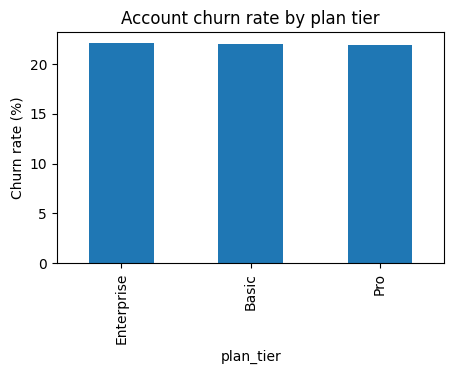

In [22]:
import matplotlib.pyplot as plt

churn_by_plan.plot(kind="bar", figsize=(5,3))
plt.ylabel("Churn rate (%)")
plt.title("Account churn rate by plan tier")
plt.show()


In [23]:
churn_by_plan


plan_tier
Enterprise    22.077922
Basic         22.023810
Pro           21.910112
Name: churn_int, dtype: float64

In [24]:
# Ensure dates are datetime
subs["start_date"] = pd.to_datetime(subs["start_date"])
subs["end_date"] = pd.to_datetime(subs["end_date"])

# Use the max start_date as a snapshot date for active subs
snapshot_date = subs["start_date"].max()

subs["end_date_filled"] = subs["end_date"].fillna(snapshot_date)

# Tenure in months (approx)
subs["tenure_months"] = (subs["end_date_filled"] - subs["start_date"]).dt.days / 30

subs[["start_date", "end_date", "end_date_filled", "tenure_months"]].head()


,start_date,end_date,end_date_filled,tenure_months
0,2023-12-23,2024-04-12,2024-04-12,3.700000
1,2024-06-11,NaT,2024-12-31,6.766667
2,2024-11-25,NaT,2024-12-31,1.200000
3,2024-11-23,2024-12-13,2024-12-13,0.666667
4,2024-01-10,NaT,2024-12-31,11.866667


In [25]:
subs["churn_int"] = subs["churn_flag"].astype(int)

tenure_by_churn = subs.groupby("churn_flag")["tenure_months"].mean()
print("Average tenure (months) by churn flag:")
print(tenure_by_churn)


Average tenure (months) by churn flag:
churn_flag
False    5.625558
True     2.935185
Name: tenure_months, dtype: float64


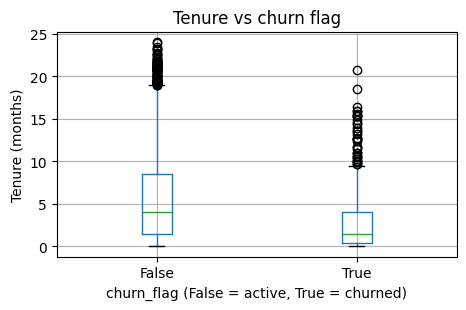

In [26]:
import matplotlib.pyplot as plt

subs.boxplot(column="tenure_months", by="churn_flag", figsize=(5,3))
plt.title("Tenure vs churn flag")
plt.suptitle("")
plt.xlabel("churn_flag (False = active, True = churned)")
plt.ylabel("Tenure (months)")
plt.show()


In [27]:
# Select useful columns from accounts
accounts_small = accounts[[
    "account_id",
    "industry",
    "country",
    "referral_source",
    "plan_tier",      # account-level initial plan
    "seats",
    "churn_int"      # account-level churn (we'll keep subscription churn as target)
]].rename(columns={"churn_int": "account_churn_int"})

# Merge subscription and account info on account_id
data = subs.merge(accounts_small, on="account_id", how="left")

data.head()


,subscription_id,account_id,start_date,end_date,plan_tier_x,seats_x,mrr_amount,arr_amount,is_trial,upgrade_flag,...,auto_renew_flag,end_date_filled,tenure_months,churn_int,industry,country,referral_source,plan_tier_y,seats_y,account_churn_int
0,S-8cec59,A-3c1a3f,2023-12-23,2024-04-12,Enterprise,14,2786,33432,False,False,...,True,2024-04-12,3.700000,1,DevTools,UK,event,Pro,1,0
1,S-0f6f44,A-9b9fe9,2024-06-11,NaT,Pro,17,833,9996,False,False,...,True,2024-12-31,6.766667,0,EdTech,AU,other,Basic,5,0
2,S-51c0d1,A-659280,2024-11-25,NaT,Enterprise,62,0,0,True,True,...,False,2024-12-31,1.200000,0,FinTech,IN,event,Enterprise,13,1
3,S-f81687,A-e7a1e2,2024-11-23,2024-12-13,Enterprise,5,995,11940,False,False,...,True,2024-12-13,0.666667,1,Cybersecurity,US,event,Enterprise,3,0
4,S-cff5a2,A-ba6516,2024-01-10,NaT,Enterprise,27,5373,64476,False,False,...,True,2024-12-31,11.866667,0,FinTech,US,ads,Pro,27,0


In [29]:
# Target variable
data["target_churn"] = data["churn_int"]  # from subs

# Simple numeric / categorical features to start
feature_cols = [
    "tenure_months",        # from subs
    "seats_x",              # seats at subscription level (rename below if needed)
    "mrr_amount",           # if present in subs
    "billing_frequency",    # monthly/annual
    "plan_tier_x",          # subscription plan tier
    "country",
    "industry",
    "referral_source",
    "is_trial_x"
]

# Keep only existing columns (in case some names differ)
feature_cols = [c for c in feature_cols if c in data.columns]
data_model = data[feature_cols + ["target_churn"]]

data_model.head()


,tenure_months,seats_x,mrr_amount,billing_frequency,plan_tier_x,country,industry,referral_source,target_churn
0,3.700000,14,2786,monthly,Enterprise,UK,DevTools,event,1
1,6.766667,17,833,monthly,Pro,AU,EdTech,other,0
2,1.200000,62,0,annual,Enterprise,IN,FinTech,event,0
3,0.666667,5,995,monthly,Enterprise,US,Cybersecurity,event,1
4,11.866667,27,5373,monthly,Enterprise,US,FinTech,ads,0


In [30]:
# Simple missing-value handling
data_model = data_model.copy()
data_model["tenure_months"] = data_model["tenure_months"].fillna(0)

# Identify categorical columns
cat_cols = data_model.select_dtypes(include=["object", "bool"]).columns.tolist()
num_cols = [c for c in data_model.columns if c not in cat_cols + ["target_churn"]]

# One-hot encode categoricals
data_encoded = pd.get_dummies(data_model, columns=cat_cols, drop_first=True)

data_encoded.head()


,tenure_months,seats_x,mrr_amount,target_churn,billing_frequency_monthly,plan_tier_x_Enterprise,plan_tier_x_Pro,country_CA,country_DE,country_FR,...,country_UK,country_US,industry_DevTools,industry_EdTech,industry_FinTech,industry_HealthTech,referral_source_event,referral_source_organic,referral_source_other,referral_source_partner
0,3.700000,14,2786,1,True,True,False,False,False,False,...,True,False,True,False,False,False,True,False,False,False
1,6.766667,17,833,0,True,False,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,1.200000,62,0,0,False,True,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
3,0.666667,5,995,1,True,True,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
4,11.866667,27,5373,0,True,True,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False


In [31]:
from sklearn.model_selection import train_test_split

X = data_encoded.drop(columns=["target_churn"])
y = data_encoded["target_churn"]

print(X.shape, y.shape)


(5000, 20) (5000,)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape)


(4000, 20) (1000, 20)


In [34]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 score :", f1_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba))


Accuracy : 0.903
Precision: 0.0
Recall   : 0.0
F1 score : 0.0
ROC-AUC  : 0.6565971389754656


C:\pyvenvs\ott_churn_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced",  # help minority churn class
    n_jobs=-1
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("RF Accuracy :", accuracy_score(y_test, y_pred_rf))
print("RF Precision:", precision_score(y_test, y_pred_rf))
print("RF Recall   :", recall_score(y_test, y_pred_rf))
print("RF F1 score :", f1_score(y_test, y_pred_rf))
print("RF ROC-AUC  :", roc_auc_score(y_test, y_proba_rf))


RF Accuracy : 0.898
RF Precision: 0.0
RF Recall   : 0.0
RF F1 score : 0.0
RF ROC-AUC  : 0.648702492265187


In [38]:
import numpy as np
import pandas as pd

importances = rf.feature_importances_
feat_names = X.columns

feat_importance_df = (
    pd.DataFrame({"feature": feat_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

print("Top 10 most important features:")
print(feat_importance_df.head(10))


Top 10 most important features:
                      feature  importance
0               tenure_months    0.315614
1                     seats_x    0.178890
2                  mrr_amount    0.176727
3   billing_frequency_monthly    0.038990
5             plan_tier_x_Pro    0.025979
11                 country_US    0.023226
12          industry_DevTools    0.023156
17    referral_source_organic    0.022023
16      referral_source_event    0.021808
19    referral_source_partner    0.020974


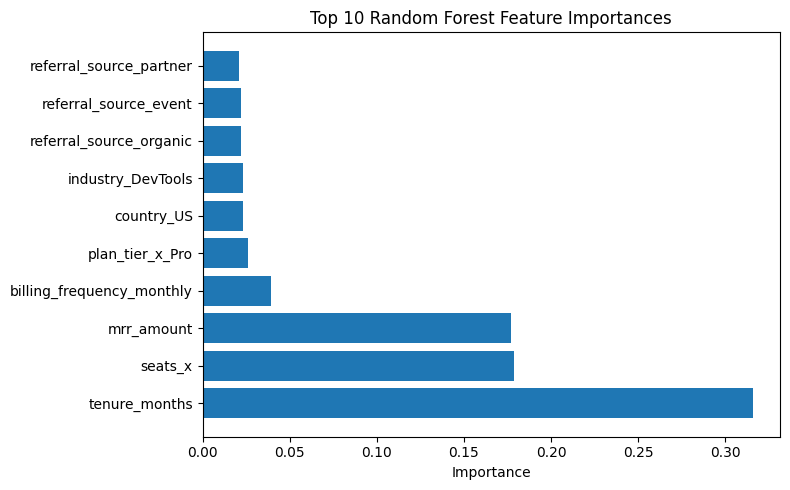

In [39]:
import matplotlib.pyplot as plt

top_n = 10
top_feats = feat_importance_df.head(top_n).sort_values("importance")  # Get top 10, sort ascending for plotting

plt.figure(figsize=(8,5))                    # Create figure 8x5 inches
plt.barh(range(len(top_feats)), top_feats["importance"])  # Horizontal bars (barh)
plt.yticks(range(len(top_feats)), top_feats["feature"])   # Label y-axis with feature names
plt.xlabel("Importance")                     # X-axis label
plt.title("Top 10 Random Forest Feature Importances")    # Title
plt.gca().invert_yaxis()                     # Flip y-axis so #1 is at top
plt.tight_layout()                           # Auto-adjust spacing
plt.show()                                   # Display plot


In [40]:
import joblib
import os

# Create models folder if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the trained model
joblib.dump(rf, "models/churn_rf_model.pkl")
print("Model saved to models/churn_rf_model.pkl")


Model saved to models/churn_rf_model.pkl


In [41]:
# Save feature names in same order
joblib.dump(X.columns.tolist(), "models/feature_names.pkl")
print("Feature names saved")


Feature names saved


In [42]:
# Test loading
loaded_model = joblib.load("models/churn_rf_model.pkl")
loaded_features = joblib.load("models/feature_names.pkl")

# Quick test prediction
sample_pred = loaded_model.predict_proba(X_test.iloc[[0]])[:, 1]
print(f"Sample churn probability: {sample_pred[0]:.3f}")


Sample churn probability: 0.030
